# The Battle of Neighborhoods

#### This Notebook corresponds to the Applied Data Science Capstone Weeks 4 & 5 Coursera Course Assignment.

## Table of Contents

<p>1. <a href="#section1">Introduction</a></p>
<p></p>
<p>2. <a href="#section1.1">Toronto City</a></p>
<p></p>
<p>3. <a href="#section2">New York City</a></p>
<p></p>
<p>4. <a href="#section3">Paris City</a></p>    


<a id='section1'></a>
# 1. Introduction

## Description of the problem and a discussion of the background:

A french family residing in Paris has to make a decision about whether to move to New York or Toronto, being both cities very diverse and the financial capitals of their respective countries. In addition, the family head has received two very similar job offers from the aforementioned cities and the final decision to where to move will be based in how similar or dissimilar they are compared to Paris.   

## Description of the data and how it will be used to solve the problem:

The Toronto and New York data related to neighborhoods and geographical coordinates are the same as in the Module 3 (Cognitive Lab, Wikipedia and Foursquare).
The Paris neighborhoods and their geographical location will be obtained using a JSON file from URL: 'https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=json&timezone=Asia/Dubai'
The venues on the neighborhoods of each city will be explored using FOURSQUARE and then will be segmented and clustered in order to determine how similar or dissimilar the cities are.
In order to achieve the above, the most representative cluster of each city will be selected and then a comparison will be made.

##### Importing some of the required libraries and dependencies.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c anaconda lxml --yes  #installs lxlm

!conda install -c conda-forge folium=0.5.0 --yes # installing folium libraries
import folium # map rendering library

#!conda install -c anaconda beautifulsoup4 --yes
#from bs4 import BeautifulSoup
#!conda install -c anaconda requests --yes
#import requests
#from requests import get

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

You will need to define the following  Foursquare API variables in a Python Code Cell to explore the neighborhoods and segment them.

<p>CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare ID </p>
<p>CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare Secret </p>
<p>VERSION = 'XXXXXXX' # Foursquare API version </p>


In [3]:
# @hidden_cell
CLIENT_ID = 'XN5T0LRS2W2KA5WHSCJZPLYMP42BSLO3W3AHP1UNN3ZGTNRC' # your Foursquare ID
CLIENT_SECRET = 'RPI2LCPILRMLRJ32QFSWFE4L5S0AHXVTJ4NSV5L13DKKI1MC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


Defining afunction to obtaing venues information from Foursquare

In [4]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

let's write a function to sort the venues in descending order.

In [5]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

<a id='item1'></a>

<a id='section1.1'></a>
## 2. Toronto City

#### Loading and Exploring he Dataset

In [6]:
#Calls all the tables from the webpage url and store them as dataframes in an array, each element is a dataframe
wiki_tables = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M", header=0) 
#print(len(wiki_tables)) #Number of dataframes in the array
df_Toronto_raw = wiki_tables[0]
#df_Toronto_raw.head()

#### Editing and adding Geographical Coordinates to the Dataframe

In [7]:
df_Toronto_edited = df_Toronto_raw.loc[df_Toronto_raw['Borough']!='Not assigned'].copy() #define a new df where Borough is different than Not assigned
df_Toronto_edited['Neighbourhood'].replace('Not assigned', df_Toronto_edited['Borough'], inplace=True)
df_Toronto_edited.rename(columns={'Neighbourhood':'Neighborhood'}, inplace=True)


In [8]:
df_temp = df_Toronto_edited.groupby(['Postcode', 'Borough'], sort=False)['Neighborhood'].apply(lambda x: ', '.join(x)).reset_index()

In [9]:
url='https://cocl.us/Geospatial_data'
df_geocodes=pd.read_csv(url,header=0)
#df_geocodes.head()

In [10]:
df_Toronto = df_temp.copy()
df_Toronto['Longitude']=''
df_Toronto['Latitude']=''
#
for i in (df_Toronto.index):
    for j in (df_geocodes.index):
        #print (i+1, df_temp.loc[i+1]['Postcode'])
        if df_Toronto.loc[i]['Postcode'] == df_geocodes.loc[j]['Postal Code']:
            df_Toronto.loc[i]['Longitude'] = df_geocodes.loc[j]['Longitude']
            df_Toronto.loc[i]['Latitude'] = df_geocodes.loc[j]['Latitude']
df_Toronto.head()


,Postcode,Borough,Neighborhood,Longitude,Latitude
0,M3A,North York,Parkwoods,-79.3297,43.7533
1,M4A,North York,Victoria Village,-79.3156,43.7259
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",-79.3606,43.6543
3,M6A,North York,"Lawrence Heights, Lawrence Manor",-79.4648,43.7185
4,M7A,Queen's Park,Queen's Park,-79.3895,43.6623


##### Using pre-defined function on each neighborhood to explore them and then create a new dataframe.

In [11]:
LIMIT = 100
toronto_venues = getNearbyVenues(names=df_Toronto['Neighborhood'],
                                   latitudes=df_Toronto['Latitude'],
                                   longitudes=df_Toronto['Longitude']
                                  )


Parkwoods
Victoria Village
Harbourfront, Regent Park
Lawrence Heights, Lawrence Manor
Queen's Park
Islington Avenue
Rouge, Malvern
Don Mills North
Woodbine Gardens, Parkview Hill
Ryerson, Garden District
Glencairn
Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park
Highland Creek, Rouge Hill, Port Union
Flemingdon Park, Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Downsview North, Wilson Heights
Thorncliffe Park
Adelaide, King, Richmond
Dovercourt Village, Dufferin
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
East Birchmount Park, Ionview, Kennedy Park
Bayview Village
CFB Toronto, Downsview East
The D

#### Let's check the size of the resulting dataframe

In [13]:
print(toronto_venues.shape)
toronto_venues.head()

(2241, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


Let's check how many venues were returned for each neighborhood

In [14]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,4,4,4,4,4,4
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",2,2,2,2,2,2
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",10,10,10,10,10,10
"Alderwood, Long Branch",9,9,9,9,9,9
"Bathurst Manor, Downsview North, Wilson Heights",18,18,18,18,18,18
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",23,23,23,23,23,23
Berczy Park,57,57,57,57,57,57


#### Let's find out how many unique categories can be curated from all the returned venues

In [15]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 279 uniques categories.


#### Analyzing Each Neighborhood

In [16]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Win

And let's examine the new dataframe size.

In [17]:
toronto_onehot.shape

(2241, 279)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [18]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Win

##### Let's confirm the new size

In [19]:
toronto_grouped.shape

(99, 279)

Now let's create the new dataframe and display the top 10 venues for each neighborhood using the return_most_common_venues function.

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Thai Restaurant,Steakhouse,Bar,Gym,Breakfast Spot,Asian Restaurant,American Restaurant,Restaurant
1,Agincourt,Lounge,Clothing Store,Breakfast Spot,Skating Rink,Drugstore,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Playground,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Drugstore
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Pizza Place,Fast Food Restaurant,Beer Store,Sandwich Place,Fried Chicken Joint,Coffee Shop,Pharmacy,Comfort Food Restaurant,Dim Sum Restaurant
4,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Skating Rink,Dance Studio,Pharmacy,Pub,Sandwich Place,Gym,Airport Service,Dessert Shop


#### Clustering Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [21]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 4, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [22]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
#neighborhoods_venues_sorted['Cluster Labels']
toronto_merged = df_Toronto.copy()


In [23]:

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.dropna(axis=0, inplace=True)
#toronto_merged['Cluster Labels']=toronto_merged['Cluster Labels'].astype('int')
#toronto_merged.head() # check the last columns!

In [24]:
toronto_merged = toronto_merged.astype({"Cluster Labels": int})

#### Mapping the clusters

Use geopy library to get the latitude and longitude values of Toronto City.

In [26]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.653963, -79.387207.


In [28]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

It is clear from above map that the cluster predominant is the one represented with red dots

#### Examining Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Toronto Cluster 1

In [29]:
toronto_c1=toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]
toronto_c1.shape

(82, 12)

#### Toronto Cluster 2

In [30]:
toronto_c2=toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]
toronto_c2.shape

(1, 12)

#### Toronto Cluster 3

In [31]:
toronto_c3=toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]
toronto_c3.shape

(2, 12)

#### Toronto Cluster 4

In [32]:
toronto_c4=toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]
toronto_c4.shape

(1, 12)

#### Toronto Cluster 5

In [33]:
toronto_c5=toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]
toronto_c5.shape

(13, 12)

 Cluster one with 82 samples is the one represented with red dots

In [34]:
df = toronto_c1.copy()
new_columnnames = ['Most common venue', 'Frequency']
df2 = pd.DataFrame()
for i in range(2,df.shape[1]):
    df1 = df.groupby(df.columns[i])['Neighborhood'].count().reset_index()
    df1.columns=new_columnnames
    df2 = df2.append(df1)
#
#print(df2)
toronto_cluster1 = df2.groupby(['Most common venue']).sum().reset_index()
toronto_cluster1.head()
#print(toronto_cluster1.shape)
#toronto_cluster1['Frequency'].sum()
#toronto_cluster1.describe()



,Most common venue,Frequency
0,Accessories Store,1
1,Airport,1
2,Airport Food Court,1
3,Airport Gate,1
4,Airport Lounge,1


In [35]:
toronto_cluster1['Frequency']=toronto_cluster1['Frequency']/toronto_cluster1['Frequency'].sum()*100
toronto_cluster1.head()

,Most common venue,Frequency
0,Accessories Store,0.121951
1,Airport,0.121951
2,Airport Food Court,0.121951
3,Airport Gate,0.121951
4,Airport Lounge,0.121951


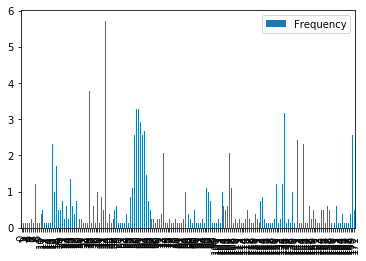

In [37]:
toronto_cluster1.plot(kind='bar')

<a id='section2'></a>
## 3. New York City

In [38]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Data downloaded!


In [39]:
neighborhoods_data = newyork_data['features']

In [40]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [41]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [42]:
df_newyork = neighborhoods.copy()
df_newyork.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [43]:
LIMIT = 100
newyork_venues = getNearbyVenues(names=df_newyork['Neighborhood'],
                                   latitudes=df_newyork['Latitude'],
                                   longitudes=df_newyork['Longitude']
                                  )


Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [44]:
print(newyork_venues.shape)
newyork_venues.head()

(10421, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381,Caribbean Restaurant
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


In [45]:
# one hot encoding
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyork_onehot['Neighborhood'] = newyork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [newyork_onehot.columns[-1]] + list(newyork_onehot.columns[:-1])
newyork_onehot = newyork_onehot[fixed_columns]

#newyork_onehot.head()

In [46]:
newyork_grouped = newyork_onehot.groupby('Neighborhood').mean().reset_index()
newyork_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Bookstore,College Cafeteria,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Fujian Restaurant,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian 

In [47]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = newyork_grouped['Neighborhood']

for ind in np.arange(newyork_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(newyork_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Supermarket,Spa,Chinese Restaurant,Deli / Bodega,Bus Station,Spanish Restaurant,Mexican Restaurant,Grocery Store,Gas Station
1,Annadale,Dance Studio,Restaurant,Bakery,Pharmacy,Train Station,Diner,Sushi Restaurant,Pizza Place,Sports Bar,Deli / Bodega
2,Arden Heights,Pharmacy,Coffee Shop,Pizza Place,Women's Store,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market
3,Arlington,Deli / Bodega,Coffee Shop,Bus Stop,American Restaurant,Boat or Ferry,Grocery Store,Flea Market,Falafel Restaurant,Farm,Farmers Market
4,Arrochar,Italian Restaurant,Bus Stop,Deli / Bodega,Athletics & Sports,Cosmetics Shop,Middle Eastern Restaurant,Bagel Shop,Outdoors & Recreation,Sandwich Place,Pizza Place


In [48]:
kclusters = 5

newyork_grouped_clustering = newyork_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(newyork_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 1, 4, 4, 4, 4, 4, 0], dtype=int32)

In [49]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
#neighborhoods_venues_sorted['Cluster Labels']
newyork_merged = df_newyork.copy()

In [50]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
newyork_merged = newyork_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
newyork_merged.dropna(axis=0, inplace=True)

In [51]:
newyork_merged = newyork_merged.astype({"Cluster Labels": int})

#### Mapping the Clusters

Use geopy library to get the latitude and longitude values of New York City.

In [52]:
address = 'New York, USA'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New Yourk City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New Yourk City are 40.7127281, -74.0060152.


In [53]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(newyork_merged['Latitude'], newyork_merged['Longitude'], newyork_merged['Neighborhood'], newyork_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The clusters represented in red and pink colors are the more respresentative.

#### Examining Clusters

#### New York Cluster 1

In [54]:
newyork_c1=newyork_merged.loc[newyork_merged['Cluster Labels'] == 0, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]
newyork_c1.shape

(125, 11)

#### New York Cluster 2

In [55]:
newyork_c2=newyork_merged.loc[newyork_merged['Cluster Labels'] == 1, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]
newyork_c2.shape

(16, 11)

#### New York Cluster 3

In [56]:
newyork_c3=newyork_merged.loc[newyork_merged['Cluster Labels'] == 2, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]
newyork_c3.shape

(4, 11)

#### New York Cluster 4

In [57]:
newyork_c4=newyork_merged.loc[newyork_merged['Cluster Labels'] == 3, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]
newyork_c4.shape

(1, 11)

#### New York Cluster 5

In [58]:
newyork_c5=newyork_merged.loc[newyork_merged['Cluster Labels'] == 4, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]
newyork_c5.shape

(159, 11)

 The cluster 5 with 159 samples is the most representative in New York

In [59]:
df = newyork_c5.copy()
new_columnnames = ['Most common venue', 'Frequency']
df2 = pd.DataFrame()
for i in range(1,df.shape[1]):
    df1 = df.groupby(df.columns[i])['Neighborhood'].count().reset_index()
    df1.columns=new_columnnames
    df2 = df2.append(df1)
#
#print(df2)
newyork_cluster5 = df2.groupby(['Most common venue']).sum().reset_index()
newyork_cluster5.head()
#newyork_cluster5.shape
#newyork_cluster5'Frequency'].sum()

,Most common venue,Frequency
0,African Restaurant,1
1,American Restaurant,27
2,Arcade,1
3,Arepa Restaurant,1
4,Art Gallery,8


In [60]:
newyork_cluster5['Frequency']=newyork_cluster5['Frequency']/newyork_cluster5['Frequency'].sum()*100
newyork_cluster5.head()

,Most common venue,Frequency
0,African Restaurant,0.062893
1,American Restaurant,1.698113
2,Arcade,0.062893
3,Arepa Restaurant,0.062893
4,Art Gallery,0.503145


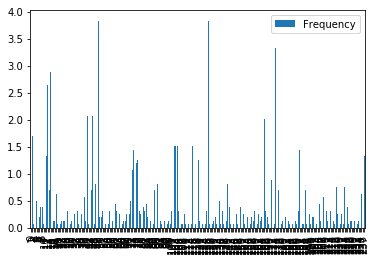

In [61]:
newyork_cluster5.plot(kind='bar')

<a id='section3'></a>
## 4. Paris City:

In [62]:
#Calls the table in json file from the webpage url and store it as dataframes in an array, some elements are arrays
#table_csv = 'https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=csv&timezone=Asia/Dubai&use_labels_for_header=true'
table_json = 'https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=json&timezone=Asia/Dubai'
#
paris_geocodes=pd.read_json(table_json)
df_Paris_raw = paris_geocodes[['fields', 'geometry']] #selects the relevant columns of imported dataframe
df_Paris_raw.head()


,fields,geometry
0,"{'n_sq_co': 750001537, 'perimetre': 4554.10435...","{'type': 'Point', 'coordinates': [2.3428025468..."
1,"{'n_sq_co': 750001537, 'perimetre': 4519.26364...","{'type': 'Point', 'coordinates': [2.3600009858..."
2,"{'n_sq_co': 750001537, 'perimetre': 24089.6662...","{'type': 'Point', 'coordinates': [2.4213249007..."
3,"{'n_sq_co': 750001537, 'perimetre': 6054.93686...","{'type': 'Point', 'coordinates': [2.3364433620..."
4,"{'n_sq_co': 750001537, 'perimetre': 5420.90843...","{'type': 'Point', 'coordinates': [2.3576296203..."


In [63]:
#Expanding column 'fields'
df_Paris_temp1 = pd.DataFrame(df_Paris_raw['fields'].values.tolist(), index=df_Paris_raw.index)
df_Paris_temp1.shape
#Expanding column 'geometry'
df_Paris_temp2 = pd.DataFrame(df_Paris_raw['geometry'].values.tolist(), index=df_Paris_raw.index)
df_Paris_temp2.shape
df_paris = df_Paris_temp1.join(df_Paris_temp2)
df_paris = pd.DataFrame(df_paris['l_aroff']).join(pd.DataFrame(df_paris['coordinates'].values.tolist(), index=df_paris.index))
paris_columns = ['Neighborhood', 'Longitude', 'Latitude'] 
# Renaming the columns
df_paris.columns=paris_columns
df_paris.head()

,Neighborhood,Longitude,Latitude
0,Bourse,2.342803,48.868279
1,Temple,2.360001,48.862872
2,Reuilly,2.421325,48.834974
3,Louvre,2.336443,48.862563
4,Hôtel-de-Ville,2.357630,48.854341


In [64]:
LIMIT=100
paris_venues = getNearbyVenues(names=df_paris['Neighborhood'],
                                   latitudes=df_paris['Latitude'],
                                   longitudes=df_paris['Longitude']
                                  )


Bourse
Temple
Reuilly
Louvre
Hôtel-de-Ville
Élysée
Observatoire
Buttes-Chaumont
Ménilmontant
Luxembourg
Opéra
Batignolles-Monceau
Vaugirard
Panthéon
Palais-Bourbon
Entrepôt
Popincourt
Gobelins
Passy
Buttes-Montmartre


In [65]:
print(paris_venues.shape)
paris_venues.head()

(1399, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bourse,48.868279,2.342803,Pizzeria Popolare,48.868252,2.343398,Pizza Place
1,Bourse,48.868279,2.342803,Le Silencio,48.868998,2.343417,Nightclub
2,Bourse,48.868279,2.342803,Le Moderne,48.868856,2.342142,French Restaurant
3,Bourse,48.868279,2.342803,Devialet,48.868108,2.343808,Music Store
4,Bourse,48.868279,2.342803,L'Appartement Sézane,48.869574,2.345060,Women's Store


In [66]:
# one hot encoding
paris_onehot = pd.get_dummies(paris_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Neighborhood'] = paris_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

paris_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auditorium,Baby Store,Bakery,Bar,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burgundian Restaurant,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Canal,Candy Store,Ch'ti Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Creperie,Cultural Center,Deli / Bodega,Dessert Shop,Diner,Dive Bar,Donut Shop,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food & Drink Shop,Fountain,French Restaurant,Furniture / Home Store,Garden,Gastropub,Gay Bar,General College & University,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Juice Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lebanese Restaurant,Liquor Store,Lounge,Lyonese Bouchon,Market,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,New American Restaurant,Nightclub,Noodle House,Okonomiyaki Restaurant,Optical Shop,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Resort,Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Science Museum,Sculpture Garden,Seafood Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,South American Restaurant,Southwestern French Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Toy / Game Store,Trail,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,Bourse,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Bourse,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bourse,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [67]:
paris_grouped = paris_onehot.groupby('Neighborhood').mean().reset_index()
paris_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auditorium,Baby Store,Bakery,Bar,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burgundian Restaurant,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Canal,Candy Store,Ch'ti Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Creperie,Cultural Center,Deli / Bodega,Dessert Shop,Diner,Dive Bar,Donut Shop,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food & Drink Shop,Fountain,French Restaurant,Furniture / Home Store,Garden,Gastropub,Gay Bar,General College & University,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Juice Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lebanese Restaurant,Liquor Store,Lounge,Lyonese Bouchon,Market,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,New American Restaurant,Nightclub,Noodle House,Okonomiyaki Restaurant,Optical Shop,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Resort,Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Science Museum,Sculpture Garden,Seafood Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,South American Restaurant,Southwestern French Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Toy / Game Store,Trail,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,Batignolles-Monceau,0.0,0.000000,0.000000,0.00,0.0,0.0,0.019231,0.0,0.000000,0.0,0.00,0.057692,0.019231,0.0,0.0,0.000000,0.00,0.00,0.0,0.019231,0.057692,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.000000,0.0,0.0,0.019231,0.0,0.0,0.019231,0.0,0.038462,0.0,0.0,0.000000,0.0,0.00,0.000000,0.019231,0.0,0.0,0.00,0.00,0.000000,0.0,0.0,0.019231,0.019231,0.0,0.00,0.00,0.0,0.00,0.00,0.019231,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.00,0.00,0.00,0.00,0.0,0.173077,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.000000,0.0,0.00,0.00,0.0,0.0,0.0,0.000000,0.0,0.134615,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.134615,0.076923,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.019231,0.0,0.0,0.000000,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.019231,0.00,0.0,0.00,0.00,0.000000,0.000000,0.0,0.038462,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.038462,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0

In [68]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = paris_grouped['Neighborhood']

for ind in np.arange(paris_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Batignolles-Monceau,French Restaurant,Italian Restaurant,Hotel,Japanese Restaurant,Bistro,Bakery,Restaurant,Plaza,Café,Convenience Store
1,Bourse,French Restaurant,Cocktail Bar,Wine Bar,Bistro,Japanese Restaurant,Italian Restaurant,Creperie,Salad Place,Bakery,Hotel
2,Buttes-Chaumont,Bar,French Restaurant,Restaurant,Hotel,Seafood Restaurant,Bistro,Café,Beer Bar,Japanese Restaurant,Supermarket
3,Buttes-Montmartre,Bar,French Restaurant,Pizza Place,Café,Vietnamese Restaurant,Coffee Shop,Hotel,Convenience Store,Restaurant,Italian Restaurant
4,Entrepôt,French Restaurant,Bistro,Hotel,Coffee Shop,Indian Restaurant,Café,Pizza Place,Japanese Restaurant,Italian Restaurant,Korean Restaurant


In [69]:
kclusters = 5

paris_grouped_clustering = paris_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 2, 2, 2, 3, 2, 2, 2, 2], dtype=int32)

In [70]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
#neighborhoods_venues_sorted['Cluster Labels']
paris_merged = df_paris.copy()

In [71]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
paris_merged.dropna(axis=0, inplace=True)

In [72]:
paris_merged = paris_merged.astype({"Cluster Labels": int})

In [73]:
paris_merged.head()

,Neighborhood,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bourse,2.342803,48.868279,2,French Restaurant,Cocktail Bar,Wine Bar,Bistro,Japanese Restaurant,Italian Restaurant,Creperie,Salad Place,Bakery,Hotel
1,Temple,2.360001,48.862872,2,French Restaurant,Italian Restaurant,Burger Joint,Bistro,Chinese Restaurant,Bakery,Restaurant,Hotel,Japanese Restaurant,Art Gallery
2,Reuilly,2.421325,48.834974,1,Zoo,Home Service,Supermarket,Monument / Landmark,Creperie,Falafel Restaurant,Furniture / Home Store,French Restaurant,Fountain,Corsican Restaurant
3,Louvre,2.336443,48.862563,2,French Restaurant,Hotel,Café,Plaza,Coffee Shop,Restaurant,Historic Site,Exhibit,Bar,Art Museum
4,Hôtel-de-Ville,2.357630,48.854341,2,French Restaurant,Ice Cream Shop,Hotel,Pastry Shop,Wine Bar,Italian Restaurant,Tea Room,Plaza,Bakery,Pedestrian Plaza


#### Mapping the clusters

Use geopy library to get the latitude and longitude values of Paris City.

In [74]:
address = 'Paris, France'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Paris City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Paris City are 48.8566101, 2.3514992.


In [76]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['Latitude'], paris_merged['Longitude'], paris_merged['Neighborhood'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In the map, it can be observed that the cluster represented with blue dots is the most reepresentative for Paris.

#### Examining the Clusters

#### Paris Cluster 1

In [77]:
paris_c1=paris_merged.loc[paris_merged['Cluster Labels'] == 0, paris_merged.columns[[0] + list(range(3, paris_merged.shape[1]))]]
paris_c1.shape

(5, 12)

#### Paris Cluster 2

In [78]:
paris_c2=paris_merged.loc[paris_merged['Cluster Labels'] == 1, paris_merged.columns[[0] + list(range(3, paris_merged.shape[1]))]]
paris_c2.shape

(1, 12)

#### Paris Cluster 3

In [79]:
paris_c3=paris_merged.loc[paris_merged['Cluster Labels'] == 2, paris_merged.columns[[0] + list(range(3, paris_merged.shape[1]))]]
paris_c3.shape
#paris_c3

(12, 12)

#### Paris Cluster 4

In [80]:
paris_c4=paris_merged.loc[paris_merged['Cluster Labels'] == 3, paris_merged.columns[[0] + list(range(3, paris_merged.shape[1]))]]
paris_c4.shape

(1, 12)

#### Paris Cluster 5

In [81]:
paris_c5=paris_merged.loc[paris_merged['Cluster Labels'] == 4, paris_merged.columns[[0] + list(range(3, paris_merged.shape[1]))]]
paris_c5.shape

(1, 12)

 Cluster 3 with a data population of 12 is the most representatie for Paris.

In [82]:
df = paris_c3.copy()
new_columnnames = ['Most common venue', 'Frequency']
df2 = pd.DataFrame()
for i in range(2,df.shape[1]):
    df1 = df.groupby(df.columns[i])['Neighborhood'].count().reset_index()
    df1.columns=new_columnnames
    df2 = df2.append(df1)
#
#print(df2)
paris_cluster3 = df2.groupby(['Most common venue']).sum().reset_index()
paris_cluster3.head()
#paris_cluster3.shape
#paris_cluster3['Frequency'].sum()

,Most common venue,Frequency
0,Art Gallery,1
1,Art Museum,1
2,Asian Restaurant,1
3,Bakery,5
4,Bar,6


In [83]:
paris_cluster3['Frequency']=paris_cluster3['Frequency']/paris_cluster3['Frequency'].sum()*100
paris_cluster3.head()

,Most common venue,Frequency
0,Art Gallery,0.833333
1,Art Museum,0.833333
2,Asian Restaurant,0.833333
3,Bakery,4.166667
4,Bar,5.000000


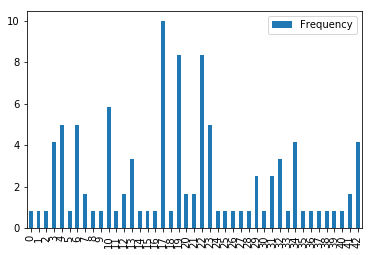

In [84]:
paris_cluster3.plot(kind='bar')

<a id='section5'></a>
## 5. Data Analysis:

Describing the most representative clusters of each city

In [85]:
toronto_cluster1.describe()

,Frequency
count,172.000000
mean,0.581395
std,0.833435
min,0.121951
25%,0.121951
50%,0.243902
75%,0.609756
max,5.731707


In [86]:
newyork_cluster5.describe()

,Frequency
count,238.000000
mean,0.420168
std,0.628927
min,0.062893
25%,0.062893
50%,0.188679
75%,0.440252
max,3.836478


In [87]:
paris_cluster3.describe()

,Frequency
count,43.000000
mean,2.325581
std,2.353921
min,0.833333
25%,0.833333
50%,0.833333
75%,3.333333
max,10.000000


From the plots on each city section it is clear that their population has some preferences. A 1% frequency cut-off will be used to ignore rows data with a frequency less or equal than the cut-off 

In [88]:
toronto_new = toronto_cluster1[toronto_cluster1['Frequency']>1].copy()
toronto_new.reset_index()
toronto_new.shape

(24, 2)

In [90]:
newyork_new = newyork_cluster5[newyork_cluster5['Frequency']>1].copy()
newyork_new.reset_index()
newyork_new.shape

(29, 2)

In [91]:
paris_new = paris_cluster3[paris_cluster3['Frequency']>1].copy()
paris_new.reset_index()
paris_new.shape

(19, 2)

Adding a new column named 'city' to the dataframes, This column contains the name of the city

In [92]:
toronto_new['city'] = 'Toronto'
newyork_new['city'] = 'New York'
paris_new['city'] = 'Paris'

Now we merge the dataframes into a single one and add six columns with zero values

In [93]:
df_final = toronto_new.append(newyork_new.append(paris_new)).reset_index().copy()
df_final['Toronto'] = 0
df_final['New_York'] = 0
df_final['Paris'] = 0
df_final['Toronto_norm'] = 0
df_final['New_York_norm'] = 0
df_final['Paris_norm'] = 0
del df_final['index']
df_final.head()

,Most common venue,Frequency,city,Toronto,New_York,Paris,Toronto_norm,New_York_norm,Paris_norm
0,American Restaurant,1.219512,Toronto,0,0,0,0,0,0
1,Bakery,2.317073,Toronto,0,0,0,0,0,0
2,Bar,1.707317,Toronto,0,0,0,0,0,0
3,Breakfast Spot,1.341463,Toronto,0,0,0,0,0,0
4,Café,3.780488,Toronto,0,0,0,0,0,0


Filling the newly defined empty columns with frequency and normalized frequency values

In [94]:
df_final.describe()

,Frequency,Toronto,New_York,Paris,Toronto_norm,New_York_norm,Paris_norm
count,72.000000,72.0,72.0,72.0,72.0,72.0,72.0
mean,2.616508,0.0,0.0,0.0,0.0,0.0,0.0
std,1.787095,0.0,0.0,0.0,0.0,0.0,0.0
min,1.006289,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.446541,0.0,0.0,0.0,0.0,0.0,0.0
50%,2.073171,0.0,0.0,0.0,0.0,0.0,0.0
75%,3.292683,0.0,0.0,0.0,0.0,0.0,0.0
max,10.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
df_final_t= df_final[df_final['city']=='Toronto'].copy()
df_final_n= df_final[df_final['city']=='New York'].copy()
df_final_p= df_final[df_final['city']=='Paris'].copy()
#
df_final_t['Toronto']=df_final_t['Frequency']
df_final_n['New_York']=df_final_n['Frequency']
df_final_p['Paris']=df_final_p['Frequency']
#
#df_final_p
df_final=df_final_t.append(df_final_n.append(df_final_p))
#
df_final['Toronto_norm'] = 100*df_final['Toronto']/df_final['Toronto'].sum()
#
df_final['New_York_norm'] = 100*df_final['New_York']/df_final['New_York'].sum()
#
df_final['Paris_norm'] = 100*df_final['Paris']/df_final['Paris'].sum()
#
df_final.head()

,Most common venue,Frequency,city,Toronto,New_York,Paris,Toronto_norm,New_York_norm,Paris_norm
0,American Restaurant,1.219512,Toronto,1.219512,0.0,0.0,2.207506,0.0,0.0
1,Bakery,2.317073,Toronto,2.317073,0.0,0.0,4.194260,0.0,0.0
2,Bar,1.707317,Toronto,1.707317,0.0,0.0,3.090508,0.0,0.0
3,Breakfast Spot,1.341463,Toronto,1.341463,0.0,0.0,2.428256,0.0,0.0
4,Café,3.780488,Toronto,3.780488,0.0,0.0,6.843267,0.0,0.0


In [96]:
df_final=df_final.groupby(['Most common venue'], sort=False).sum()
##df_final.set_index('Most common venue', inplace=True)
df_final

,Frequency,Toronto,New_York,Paris,Toronto_norm,New_York_norm,Paris_norm
Most common venue,,,,,,,
American Restaurant,2.917625,1.219512,1.698113,0.000000,2.207506,3.195266,0.000000
Bakery,9.125249,2.317073,2.641509,4.166667,4.194260,4.970414,5.208333
Bar,9.600399,1.707317,2.893082,5.000000,3.090508,5.443787,6.250000
Breakfast Spot,1.341463,1.341463,0.000000,0.000000,2.428256,0.000000,0.000000
Café,11.689293,3.780488,2.075472,5.833333,6.843267,3.905325,7.291667
Coffee Shop,12.901519,5.731707,3.836478,3.333333,10.375276,7.218935,4.166667
Dim Sum Restaurant,1.097561,1.097561,0.000000,0.000000,1.986755,0.000000,0.000000
Diner,2.560976,2.560976,0.000000,0.000000,4.635762,0.000000,0.000000
Discount Store,3.292683,3.292683,0.000000,0.000000,5.960265,0.000000,0.000000


Preparing the comparative plots

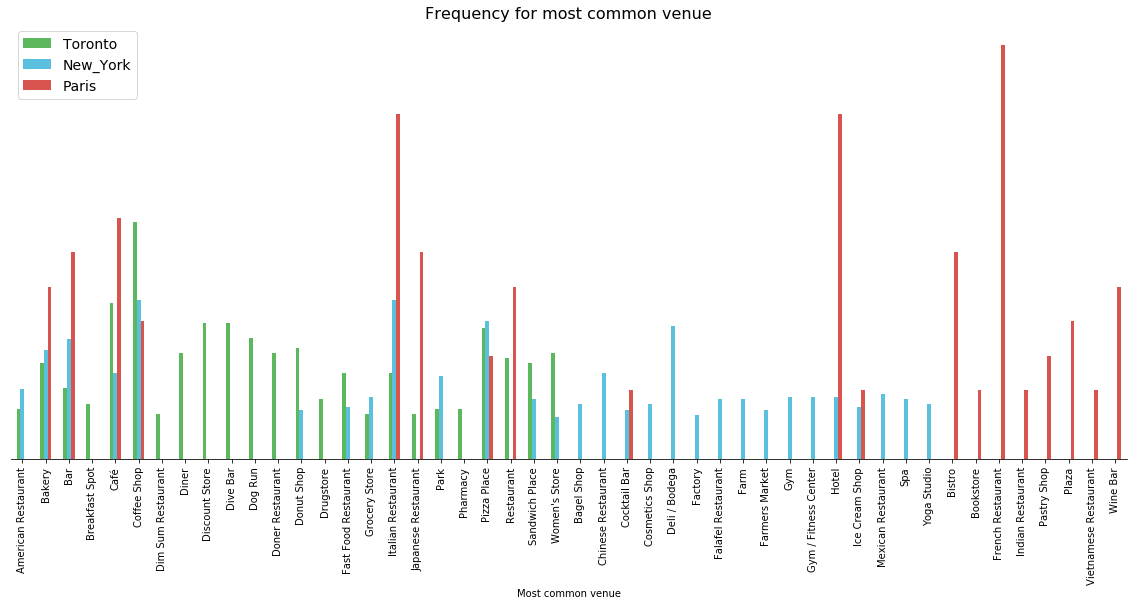

In [97]:
y_data=['Toronto', 'New_York', 'Paris']
ax = df_final[y_data].plot(kind='bar', figsize=(20, 8), color=['#5cb85c', '#5bc0de', '#d9534f'])
ax.set_title('Frequency for most common venue', fontsize=16)
ax.legend(fontsize=14)
ax.axes.get_yaxis().set_visible(False)
# Hide the right and top spines
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#

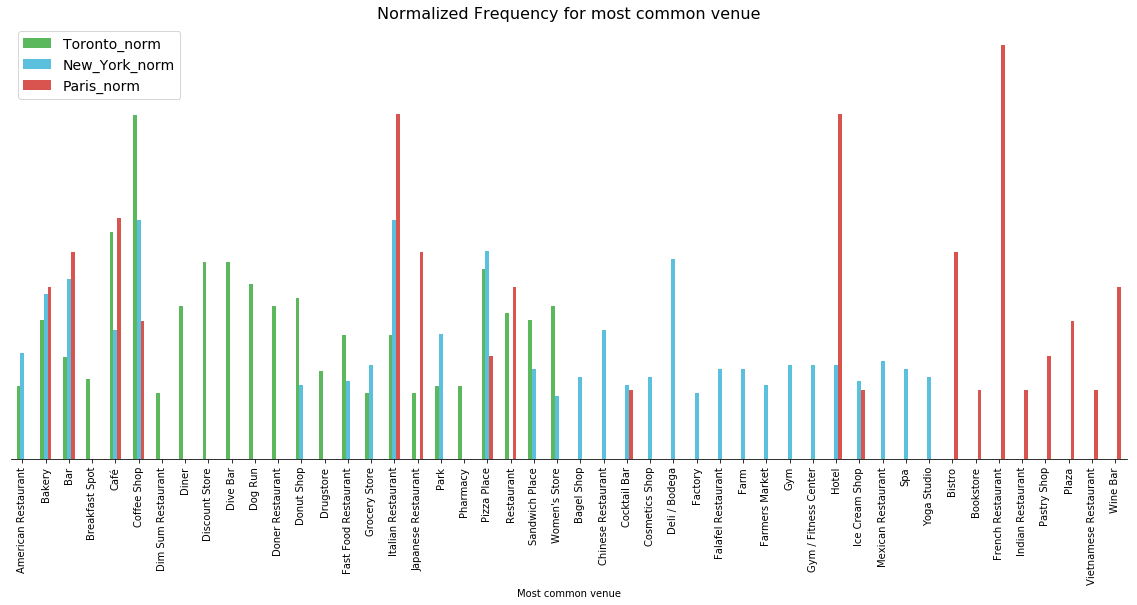

In [98]:
y_data_norm=['Toronto_norm', 'New_York_norm', 'Paris_norm']
ax = df_final[y_data_norm].plot(kind='bar', figsize=(20, 8), color=['#5cb85c', '#5bc0de', '#d9534f'])
ax.set_title('Normalized Frequency for most common venue', fontsize=16)
ax.legend(fontsize=14)
ax.axes.get_yaxis().set_visible(False)
# Hide the right and top spines
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#

The results are veryintersting. It is clear that even though there are some similarities among these three multi-cultural citoes, there are also fifferences among them. The plots  show that out of the 19 most common filtered venues for Paris, only 06 type of venues are most common simulataneously on these three cities. Besides, Paris shares 03 type of venues exclusively with New York and 02 type of venues exclusively with Toronto. 
Finally, there are 08 type of common venues (Bistro, Bookstore, French Restaurant, Indian Restaurant, Pastry Shop, Vietnamise Restaurant and Wine Bar) which represents 42%, this difference makes Paris distinctive from New York and Toronto. However, there are also similarities because Paris shares 09 (47%) common venues with New York and 08 (42%) with Toronto.

In conclusion, moving from one country to another always represents a challenge. In this case, the analysis shows that people from New York shares more similarities with Paris than Toronto in terms of type of venues frequented by people but the degree of similarity is only 47%. Besides, Toronto is not far  on this field and more study including other variables need to be taken account. For instance, French is a language that it is spoken widely in Toronto but not in New York. Similarly, parameters like wheater, living cost, etc. need to be considered.   

### Thank you reviewing my Assignment!

This notebook was modified by Carlos Pinillos from the one created by [Alex Aklson](https://www.linkedin.com/in/aklson/) and [Polong Lin](https://www.linkedin.com/in/polonglin/) which is part of a course on Coursera called Applied Data Science Capstone. If you accessed this notebook outside the course, you can take this course online by clicking [here](http://cocl.us/DP0701EN_Coursera_Week3_LAB2).

<hr>

Copyright &copy; 2019 [Cognitive Class](https://cognitiveclass.ai/?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). The original notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).